##**Импорт библиотек**

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPool1D, Input, Normalization

##**Пользовательские функции**

In [3]:
# Функция, маскирующая выбросы по определенному столбцу на основе межквартильного расстояния
# вх - df_col - столбец исходного датасета, по которому маскируются строки с выбросами
# вх - verbose - выводить на экран или нет сопутствующую информацию
# вых - (маска строк без выбросов, количество выбросов)
def mask_iqr_outliers(df_col, verbose = False):
  q1 = df_col.describe()['25%']
  q3 = df_col.describe()['75%']
  iqr = q3 - q1
  k = 1.5
  # сохраним индексы, не являющиеся экстремальными выбросами
  if iqr > 0:
    mask_ok = list((df_col > q1 - k * iqr) & (df_col < q3 + k * iqr))
    outs_count = len(df_col) - sum(mask_ok)
  else:
    mask_ok = [True] * df_col.shape[0]
    outs_count = 0
  if verbose == True:
    print(f'min = {q1 - k * iqr} , max = {q3 + k * iqr}, iqr = {iqr}, outs = {outs_count}')
  return (mask_ok, outs_count)

# Функция, маскирующая выбросы по определенному столбцу на основе правила 3 сигм
# вх - df_col - столбец исходного датасета, по которому маскируются строки с выбросами
# вх - verbose - выводить на экран или нет сопутствующую информацию
# вых - (маска строк без выбросов, количество выбросов)
def mask_3sigm_outliers(df_col, verbose = False):
  df_col_z = (df_col - df_col.mean()) / df_col.std()
  # сохраним индексы, не являющиеся выбросами - значения внутри диапазона 3х сигм
  mask_ok = list(abs(df_col_z) <= 3)
  outs_count = len(df_col) - sum(mask_ok)
  if verbose == True:
    print(f'df_col_z = {df_col_z} , outs = {outs_count}')
  return (mask_ok, outs_count)

# Функция, маскирующая выбросы по определенному столбцу на основе LocalOutlierFactor
# вх - df_col - столбец исходного датасета, по которому маскируются строки с выбросами
# вх - verbose - выводить на экран или нет сопутствующую информацию
# вых - (маска строк без выбросов, количество выбросов)
def mask_lof_outliers(df_col, verbose = False):
  lof = LocalOutlierFactor(n_neighbors=20, metric='manhattan')
  # сохраним индексы, не являющиеся выбросами (= 1, выбросы = -1)
  mask_ok = lof.fit_predict(np.array(df_col).reshape(-1, 1))
  mask_ok = list(map(lambda x: x == 1, mask_ok))
  outs_count = len(df_col) - sum(mask_ok)
  if verbose == True:
    print(f'outs = {outs_count}')
  return (mask_ok, outs_count)

# Функция, маскирующая выбросы по определенному столбцу на основе IsolationForest
# вх - df_col - столбец исходного датасета, по которому маскируются строки с выбросами
# вх - verbose - выводить на экран или нет сопутствующую информацию
# вых - (маска строк без выбросов, количество выбросов)
def mask_isf_outliers(df_col, verbose = False):
  isf = IsolationForest(n_estimators=50, random_state=42, contamination=0.04)
  # сохраним индексы, не являющиеся выбросами (= 1, выбросы = -1)
  mask_ok = isf.fit_predict(np.array(df_col).reshape(-1, 1))
  mask_ok = list(map(lambda x: x == 1, mask_ok))
  outs_count = len(df_col) - sum(mask_ok)
  if verbose == True:
    print(f'outs = {outs_count}')
  return (mask_ok, outs_count)

# Функция, маскирующая выбросы по списку столбцов заданным методом
# вх - df - исходный датасет
# вх - cols - столбцы исходного датасета, по которым считаются строки с выбросами
# вх - func - функция маскирования выбросов
# вх - verbose - выводить на экран или нет сопутствующую информацию
# вых - (список столбцов с выбросами, список счетчиков выбросов по столбцам)
def get_outliers(df, cols, func = mask_iqr_outliers, verbose = False):
  if len(cols) == 0:
    cols = df.columns
  outs_lst = []
  outs_cnt = []
  for col in cols:
    mask, count = func(df[col], verbose)
    if count > 0:
      outs_lst.append(col)
      outs_cnt.append(count)
  return (outs_lst, outs_cnt)

# Функция, удаляющая экстремальные выбросы по заданным столбцам
# вх - df - исходный датасет
# вх - cols_outs - список столбцов с экстремальными выбросами
# вх - func - функция маскирования выбросов
# вых - датасет, созданный из исходного после удаления экстремальных выбросов
def drop_outliers(df, cols_outs, func = mask_iqr_outliers):
  mask_res = [True] * df.shape[0]
  df_res = df.copy()
  for col in cols_outs:
    mask, count = func(df_res[col])
    mask_res = np.bitwise_and(mask_res, mask)
  df_res = df_res[mask_res]  
  df_res = df_res.reset_index()
  df_res.drop(['index'], axis = 1, inplace = True)
  df_res.index.name = 'index'
  return df_res

# Функция, строящая для заданного параметра boxplot и гистограмму с функцией плотности распределения
# вх - data - исходный датасет, 
# вх - col - список имён столбцов - параметров для построения графиков,
# вх - hue - столбец, по которому нужно разделить графики
# вых - сетка графиков в три столбца, для каждого параметра два графика друг под другом
def plot_hist_box (data, col, hue = None):
  if hue != None:
    col = col[col != hue]
  # Посчитаем нужное количество строк при 3х столбцах
  grid_rows = int(np.ceil(len(col) / 3))
  # В сетке будет в 2 раза больше рядов, т.к. на каждый признак по 2 графика
  spec = mpl.gridspec.GridSpec(ncols = 3,
                               nrows = grid_rows * 2,
                               height_ratios = [1, 4] * grid_rows,
                               hspace = 0.3)
  fig = plt.figure(figsize = (18, grid_rows * 2 * 4))   # на каждый ряд по 4
  for i in range(grid_rows):                  # обход строк
    for j in range(3):                        # обход столбцов 
      if (3 * i + j) < len(col):          # если еще не все требуемые столбцы обошли
        ax = fig.add_subplot(spec[i * 2, j])
        sns.boxplot(data = data,
                    x = data[col[3 * i + j]],
                    palette = 'Set2',
                    ax = ax).set(xlabel = None)
        ax = fig.add_subplot(spec[i * 2 + 1, j])
        sns.histplot(x = data[col[3 * i + j]],
                     kde = True,
                     ax = ax,
                     data = data,
                     stat = 'probability',
                     palette = 'Set2',
                     hue = hue).set(ylabel = None)

# Функция для отображения изменения метрик в процессе обучения модели
# вх - history - история обучения модели
def plot_history(history):
  plt.figure()
  plt.xlabel('Итерации обучения (эпохи)')
  plt.ylabel('Средняя абсолютная ошибка (Mean Abs Error))')
  plt.plot(history.epoch, np.array(history.history['mae']), 
           label='Обучение')
  plt.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Валидация')
  plt.legend()
  plt.grid(True)
  plt.ylim([0, max(history.history['val_mae'])])

# Функция для отображения графика предсказанных значений от реальных
# вх - test_labels - реальные значения
# вх - test_predictions - предсказанные значения
def plot_prediction(test_labels, test_predictions):
  plt.figure()
  plt.scatter(test_labels, test_predictions)
  plt.xlabel('Реальные значения')
  plt.ylabel('Предсказанные значения')
  plt.axis('equal')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  plt.plot([-10000, 10000],[-10000,10000])

  plt.figure()
  error = test_predictions - test_labels
  plt.hist(error, bins = 50)
  plt.xlabel("Ошибка предсказания")
  plt.ylabel("Количество")                       

##**Загрузка датасета**

In [4]:
# Прочитаем два файла Excel с данными
path1 = '/content/drive/MyDrive/Colab Notebooks/VKR/X_bp.xlsx'
path2 = '/content/drive/MyDrive/Colab Notebooks/VKR/X_nup.xlsx'
df1 = pd.read_excel(path1)
df2 = pd.read_excel(path2)

In [5]:
# Проверим первый датафрейм
df1.head(3)

,Unnamed: 0,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2"
0,0.0,1.857143,2030.0,738.736842,30.0,22.267857,100.000000,210.0,70.0,3000.0,220.0
1,1.0,1.857143,2030.0,738.736842,50.0,23.750000,284.615385,210.0,70.0,3000.0,220.0
2,2.0,1.857143,2030.0,738.736842,49.9,33.000000,284.615385,210.0,70.0,3000.0,220.0


In [6]:
# Удалим лишний столбец с индексами 'Unnamed: 0'
df1 = df1.drop('Unnamed: 0', axis = 1)
df1.head(3)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2"
0,1.857143,2030.0,738.736842,30.0,22.267857,100.000000,210.0,70.0,3000.0,220.0
1,1.857143,2030.0,738.736842,50.0,23.750000,284.615385,210.0,70.0,3000.0,220.0
2,1.857143,2030.0,738.736842,49.9,33.000000,284.615385,210.0,70.0,3000.0,220.0


In [7]:
# Проверим второй датафрейм
df2.head(3)

,Unnamed: 0,"Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,0.0,0.0,4.0,57.0
1,1.0,0.0,4.0,60.0
2,2.0,0.0,4.0,70.0


In [8]:
# Удалим лишний столбец с индексами 'Unnamed: 0'
df2 = df2.drop('Unnamed: 0', axis = 1)
df2.head(3)

,"Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,0.0,4.0,57.0
1,0.0,4.0,60.0
2,0.0,4.0,70.0


In [9]:
# Объединим оба датафрейма в один методом INNER
df = df1.join(df2, how = 'inner')
df.head(3)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,1.857143,2030.0,738.736842,30.0,22.267857,100.000000,210.0,70.0,3000.0,220.0,0.0,4.0,57.0
1,1.857143,2030.0,738.736842,50.0,23.750000,284.615385,210.0,70.0,3000.0,220.0,0.0,4.0,60.0
2,1.857143,2030.0,738.736842,49.9,33.000000,284.615385,210.0,70.0,3000.0,220.0,0.0,4.0,70.0


##**Очистка и форматирование данных**

In [10]:
# Проверим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
 10  Угол нашивки, град                    1023 non-null   float64
 11  Шаг нашивки      

Имеем 1023 наблюдений и 13 характеристик.

In [11]:
# Выведем описательную статистику наших данных
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Соотношение матрица-наполнитель,1023.0,2.930366,0.913222,0.389403,2.317887,2.906878,3.552660,5.591742
"Плотность, кг/м3",1023.0,1975.734888,73.729231,1731.764635,1924.155467,1977.621657,2021.374375,2207.773481
"модуль упругости, ГПа",1023.0,739.923233,330.231581,2.436909,500.047452,739.664328,961.812526,1911.536477
"Количество отвердителя, м.%",1023.0,110.570769,28.295911,17.740275,92.443497,110.564840,129.730366,198.953207
"Содержание эпоксидных групп,%_2",1023.0,22.244390,2.406301,14.254985,20.608034,22.230744,23.961934,33.000000
"Температура вспышки, С_2",1023.0,285.882151,40.943260,100.000000,259.066528,285.896812,313.002106,413.273418
"Поверхностная плотность, г/м2",1023.0,482.731833,281.314690,0.603740,266.816645,451.864365,693.225017,1399.542362
"Модуль упругости при растяжении, ГПа",1023.0,73.328571,3.118983,64.054061,71.245018,73.268805,75.356612,82.682051
"Прочность при растяжении, МПа",1023.0,2466.922843,485.628006,1036.856605,2135.850448,2459.524526,2767.193119,3848.436732
"Потребление смолы, г/м2",1023.0,218.423144,59.735931,33.803026,179.627520,219.198882,257.481724,414.590628


Все значения неотрицательные, разброс параметров существенный.

In [12]:
# Проверим количество пропусков
df.isna().sum()

Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
dtype: int64

Пропуски в данных отсутствуют.

In [13]:
# Посчитаем количество уникальных значений
df.nunique()

Соотношение матрица-наполнитель         1014
Плотность, кг/м3                        1013
модуль упругости, ГПа                   1020
Количество отвердителя, м.%             1005
Содержание эпоксидных групп,%_2         1004
Температура вспышки, С_2                1003
Поверхностная плотность, г/м2           1004
Модуль упругости при растяжении, ГПа    1004
Прочность при растяжении, МПа           1004
Потребление смолы, г/м2                 1003
Угол нашивки, град                         2
Шаг нашивки                              989
Плотность нашивки                        988
dtype: int64

Параметр "Угол нашивки, град" принимает всего два значения - его можно будет преобразовать в категориальный признак.

In [14]:
# Проверим наличие выбросов

# На основе межквартильного расстояния
col1, cnt1 = get_outliers(df, df.columns)
df_outs_extr = pd.DataFrame(data = np.vstack((col1, cnt1)).T, columns = ['Параметр', 'IQR'])

# На основе правила трех сигм
col2, cnt2 = get_outliers(df, df.columns, mask_3sigm_outliers)
df_outs_3sigm = pd.DataFrame(data = np.vstack((col2, cnt2)).T, columns = ['Параметр', '3Sigm'])

# На основе LocalOutlierFactor
col3, cnt3 = get_outliers(df, df.columns, mask_lof_outliers)
df_outs_lof = pd.DataFrame(data = np.vstack((col3, cnt3)).T, columns = ['Параметр', 'LOF'])

# Соберем результаты в один датафрейм
df_outs = pd.DataFrame()
df_outs['Параметр'] = df.columns.T
df_outs = df_outs.join(df_outs_extr.set_index('Параметр'), on='Параметр')
df_outs = df_outs.join(df_outs_3sigm.set_index('Параметр'), on='Параметр')
df_outs = df_outs.join(df_outs_lof.set_index('Параметр'), on='Параметр')
df_outs = df_outs.fillna(0)
df_outs

,Параметр,IQR,3Sigm,LOF
0,Соотношение матрица-наполнитель,6,0,11
1,"Плотность, кг/м3",9,3,10
2,"модуль упругости, ГПа",2,2,6
3,"Количество отвердителя, м.%",14,2,15
4,"Содержание эпоксидных групп,%_2",2,2,10
5,"Температура вспышки, С_2",8,3,9
6,"Поверхностная плотность, г/м2",2,2,7
7,"Модуль упругости при растяжении, ГПа",6,0,12
8,"Прочность при растяжении, МПа",11,0,5
9,"Потребление смолы, г/м2",8,3,20


In [15]:
# Удалим выбросы методом 3 сигм
df_fix = drop_outliers(df, col2, func = mask_3sigm_outliers)
df_fix

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
index,,,,,,,,,,,,,
0,1.857143,2030.000000,738.736842,50.000000,23.750000,284.615385,210.000000,70.000000,3000.000000,220.000000,0.0,4.000000,60.000000
1,1.857143,2030.000000,738.736842,129.000000,21.250000,300.000000,210.000000,70.000000,3000.000000,220.000000,0.0,5.000000,47.000000
2,2.771331,2030.000000,753.000000,111.860000,22.267857,284.615385,210.000000,70.000000,3000.000000,220.000000,0.0,5.000000,57.000000
3,2.767918,2000.000000,748.000000,111.860000,22.267857,284.615385,210.000000,70.000000,3000.000000,220.000000,0.0,5.000000,60.000000
4,2.569620,1910.000000,807.000000,111.860000,22.267857,284.615385,210.000000,70.000000,3000.000000,220.000000,0.0,5.000000,70.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.271346,1952.087902,912.855545,86.992183,20.123249,324.774576,209.198700,73.090961,2387.292495,125.007669,90.0,9.076380,47.019770
996,3.444022,2050.089171,444.732634,145.981978,19.599769,254.215401,350.660830,72.920827,2360.392784,117.730099,90.0,10.565614,53.750790
997,3.280604,1972.372865,416.836524,110.533477,23.957502,248.423047,740.142791,74.734344,2662.906040,236.606764,90.0,4.161154,67.629684


##**Разведочный анализ данных**

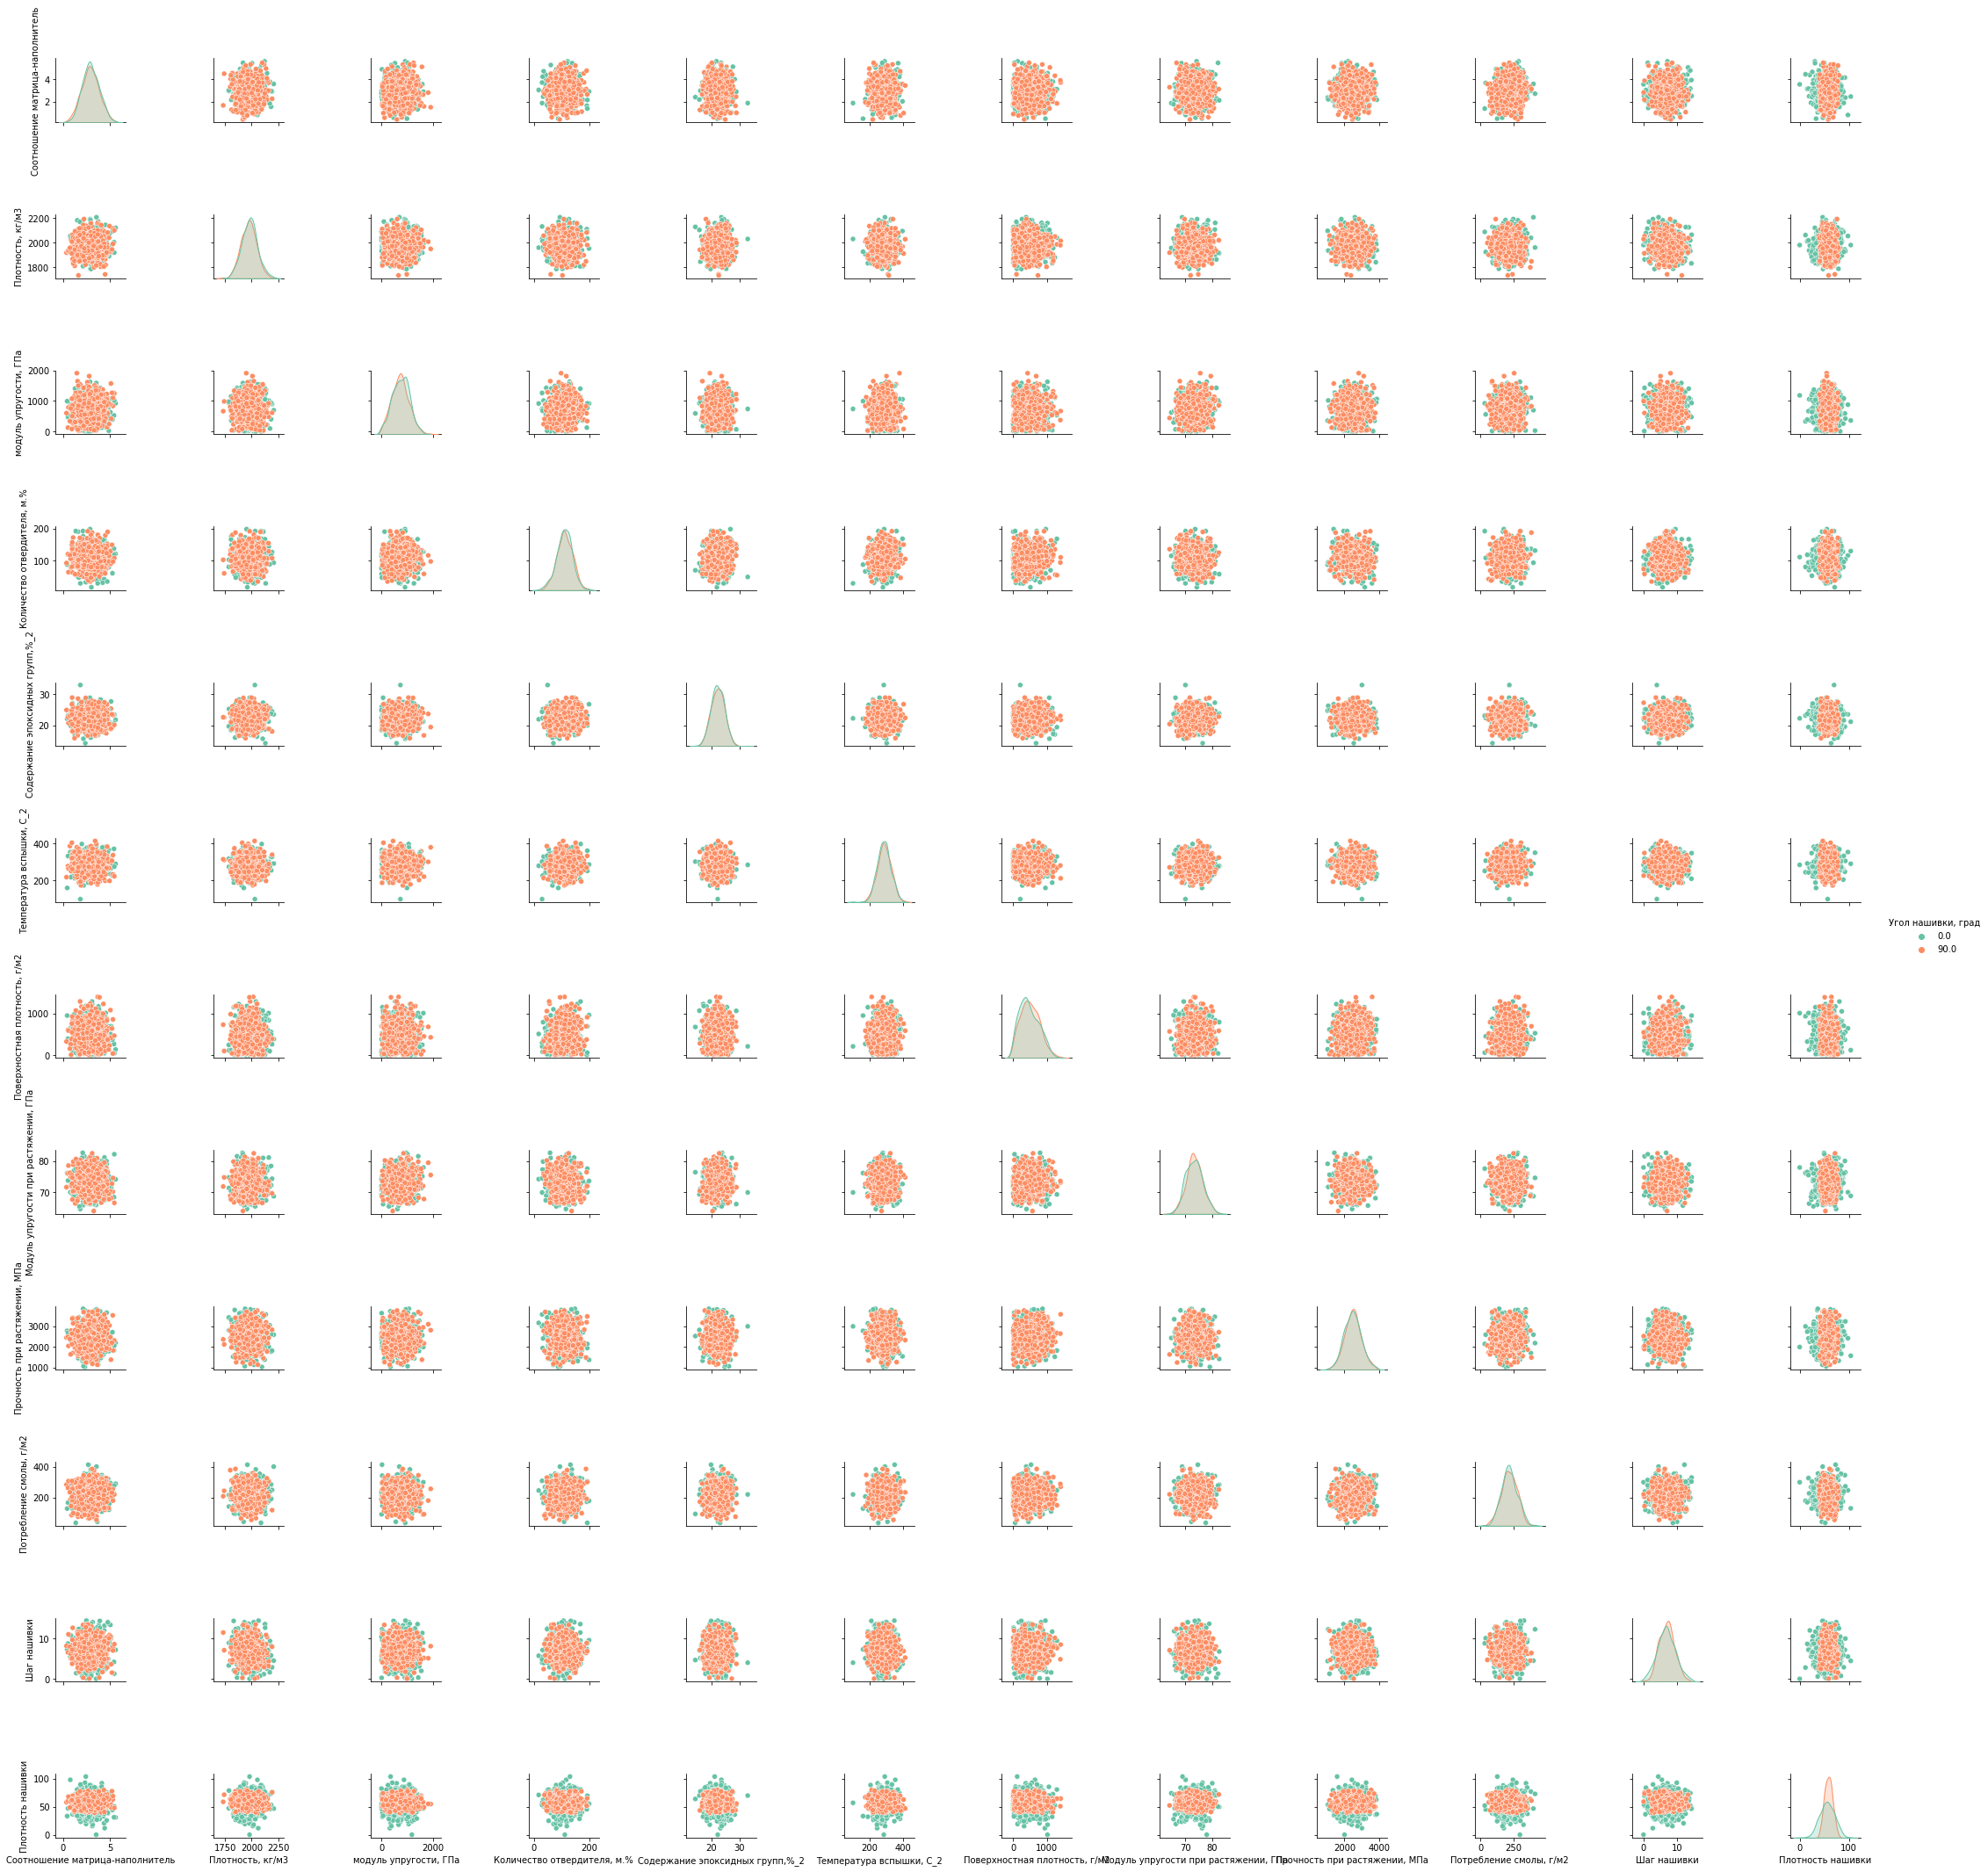

In [ ]:
# Построим парные графики для данных до удаления выбросов
# Параметр "Угол нашивки, град" будем использовать для разделения графиков по его двум значениям.
sns.pairplot(df, hue='Угол нашивки, град', palette='Set2')

Линейной зависимости между параметрами не заметно.
Наибольшая разница между графиками для разных углов нашивки заметна для параметра "Плотность нашивки". Для угла нашивки 90 градусов плотность нашивки имеет меньший разброс значений.

In [ ]:
# Посмотрим на коэффициенты корреляции Пирсона
df.corr()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
Соотношение матрица-наполнитель,1.000000,0.003841,0.031700,-0.006445,0.019766,-0.004776,-0.006272,-0.008411,0.024148,0.072531,-0.031073,0.036437,-0.004652
"Плотность, кг/м3",0.003841,1.000000,-0.009647,-0.035911,-0.008278,-0.020695,0.044930,-0.017602,-0.069981,-0.015937,-0.068474,-0.061015,0.080304
"модуль упругости, ГПа",0.031700,-0.009647,1.000000,0.024049,-0.006804,0.031174,-0.005306,0.023267,0.041868,0.001840,-0.025417,-0.009875,0.056346
"Количество отвердителя, м.%",-0.006445,-0.035911,0.024049,1.000000,-0.000684,0.095193,0.055198,-0.065929,-0.075375,0.007446,0.038570,0.014887,0.017248
"Содержание эпоксидных групп,%_2",0.019766,-0.008278,-0.006804,-0.000684,1.000000,-0.009769,-0.012940,0.056828,-0.023899,0.015165,0.008052,0.003022,-0.039073
"Температура вспышки, С_2",-0.004776,-0.020695,0.031174,0.095193,-0.009769,1.000000,0.020121,0.028414,-0.031763,0.059954,0.020695,0.025795,0.011391
"Поверхностная плотность, г/м2",-0.006272,0.044930,-0.005306,0.055198,-0.012940,0.020121,1.000000,0.036702,-0.003210,0.015692,0.052299,0.038332,-0.049923
"Модуль упругости при растяжении, ГПа",-0.008411,-0.017602,0.023267,-0.065929,0.056828,0.028414,0.036702,1.000000,-0.009009,0.050938,0.023003,-0.029468,0.006476
"Прочность при растяжении, МПа",0.024148,-0.069981,0.041868,-0.075375,-0.023899,-0.031763,-0.003210,-0.009009,1.000000,0.028602,0.023398,-0.059547,0.019604
"Потребление смолы, г/м2",0.072531,-0.015937,0.001840,0.007446,0.015165,0.059954,0.015692,0.050938,0.028602,1.000000,-0.015334,0.013394,0.012239


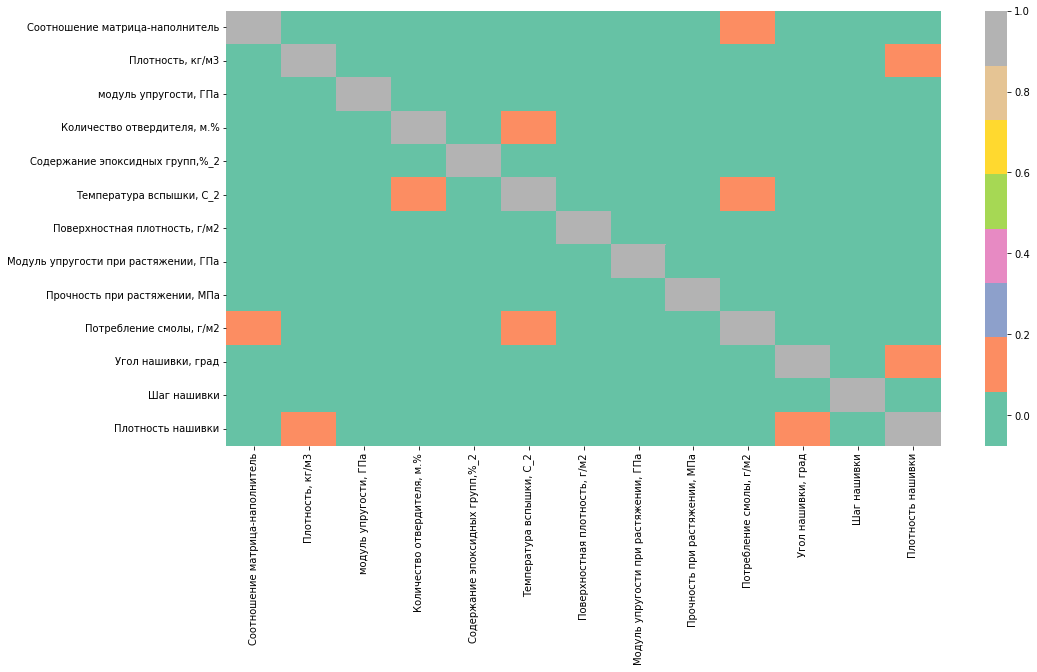

In [ ]:
# Построим тепловую карту для коэффициентов корреляции Пирсона
plt.figure(figsize = (16,8))
sns.heatmap(df.corr(), cmap = 'Set2')

Все коэффициенты стремятся к 0 кроме 5 значений, которые также невелики - не превосходят 0.09.

In [44]:
# Найдем все корелляции с целевыми переменными и отсортируем их
corr_data1 = df.corr()['Соотношение матрица-наполнитель'].sort_values()
corr_data1

Угол нашивки, град                     -0.031073
Модуль упругости при растяжении, ГПа   -0.008411
Количество отвердителя, м.%            -0.006445
Поверхностная плотность, г/м2          -0.006272
Температура вспышки, С_2               -0.004776
Плотность нашивки                      -0.004652
Плотность, кг/м3                        0.003841
Содержание эпоксидных групп,%_2         0.019766
Прочность при растяжении, МПа           0.024148
модуль упругости, ГПа                   0.031700
Шаг нашивки                             0.036437
Потребление смолы, г/м2                 0.072531
Соотношение матрица-наполнитель         1.000000
Name: Соотношение матрица-наполнитель, dtype: float64

In [45]:
corr_data2 = df.corr()['Модуль упругости при растяжении, ГПа'].sort_values()
corr_data2

Количество отвердителя, м.%            -0.065929
Шаг нашивки                            -0.029468
Плотность, кг/м3                       -0.017602
Прочность при растяжении, МПа          -0.009009
Соотношение матрица-наполнитель        -0.008411
Плотность нашивки                       0.006476
Угол нашивки, град                      0.023003
модуль упругости, ГПа                   0.023267
Температура вспышки, С_2                0.028414
Поверхностная плотность, г/м2           0.036702
Потребление смолы, г/м2                 0.050938
Содержание эпоксидных групп,%_2         0.056828
Модуль упругости при растяжении, ГПа    1.000000
Name: Модуль упругости при растяжении, ГПа, dtype: float64

In [46]:
corr_data3 = df.corr()['Прочность при растяжении, МПа'].sort_values()
corr_data3

Количество отвердителя, м.%            -0.075375
Плотность, кг/м3                       -0.069981
Шаг нашивки                            -0.059547
Температура вспышки, С_2               -0.031763
Содержание эпоксидных групп,%_2        -0.023899
Модуль упругости при растяжении, ГПа   -0.009009
Поверхностная плотность, г/м2          -0.003210
Плотность нашивки                       0.019604
Угол нашивки, град                      0.023398
Соотношение матрица-наполнитель         0.024148
Потребление смолы, г/м2                 0.028602
модуль упругости, ГПа                   0.041868
Прочность при растяжении, МПа           1.000000
Name: Прочность при растяжении, МПа, dtype: float64

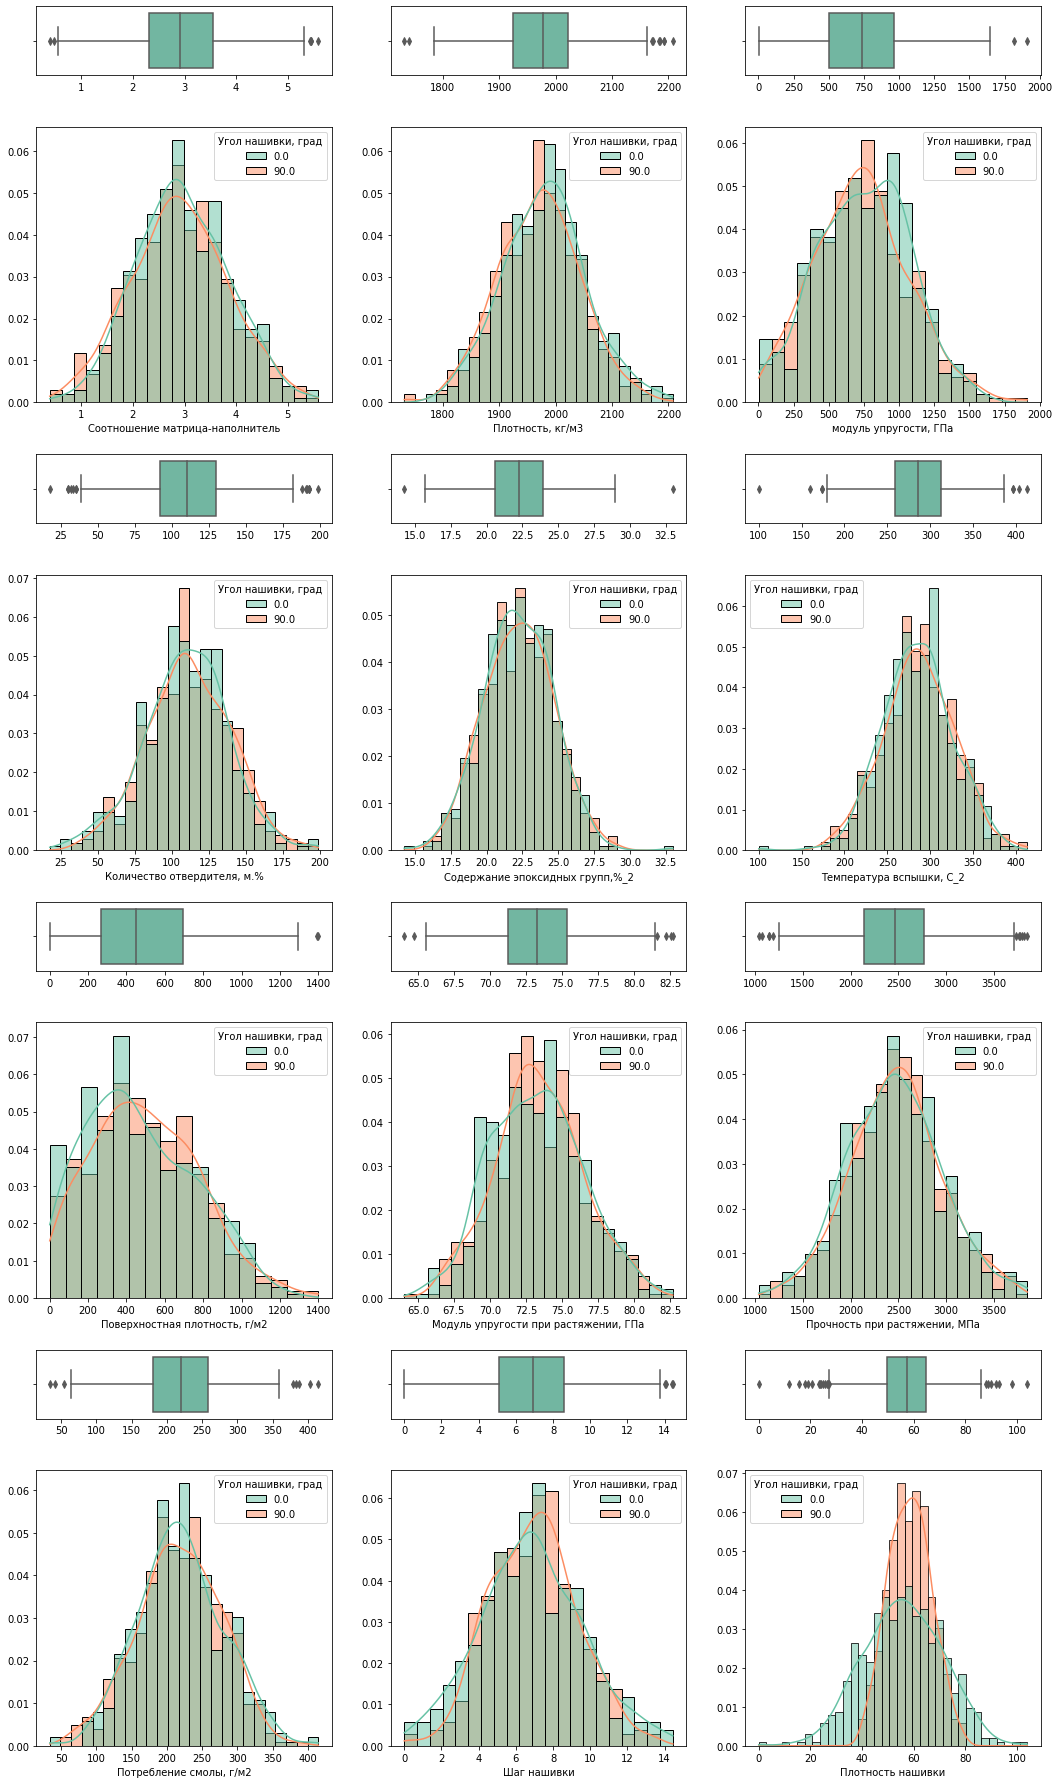

In [ ]:
# Построим ящики с усами и графики плотности распределения для всех признаков с разделением по углу нашивки
plot_hist_box(df, df.columns, 'Угол нашивки, град')

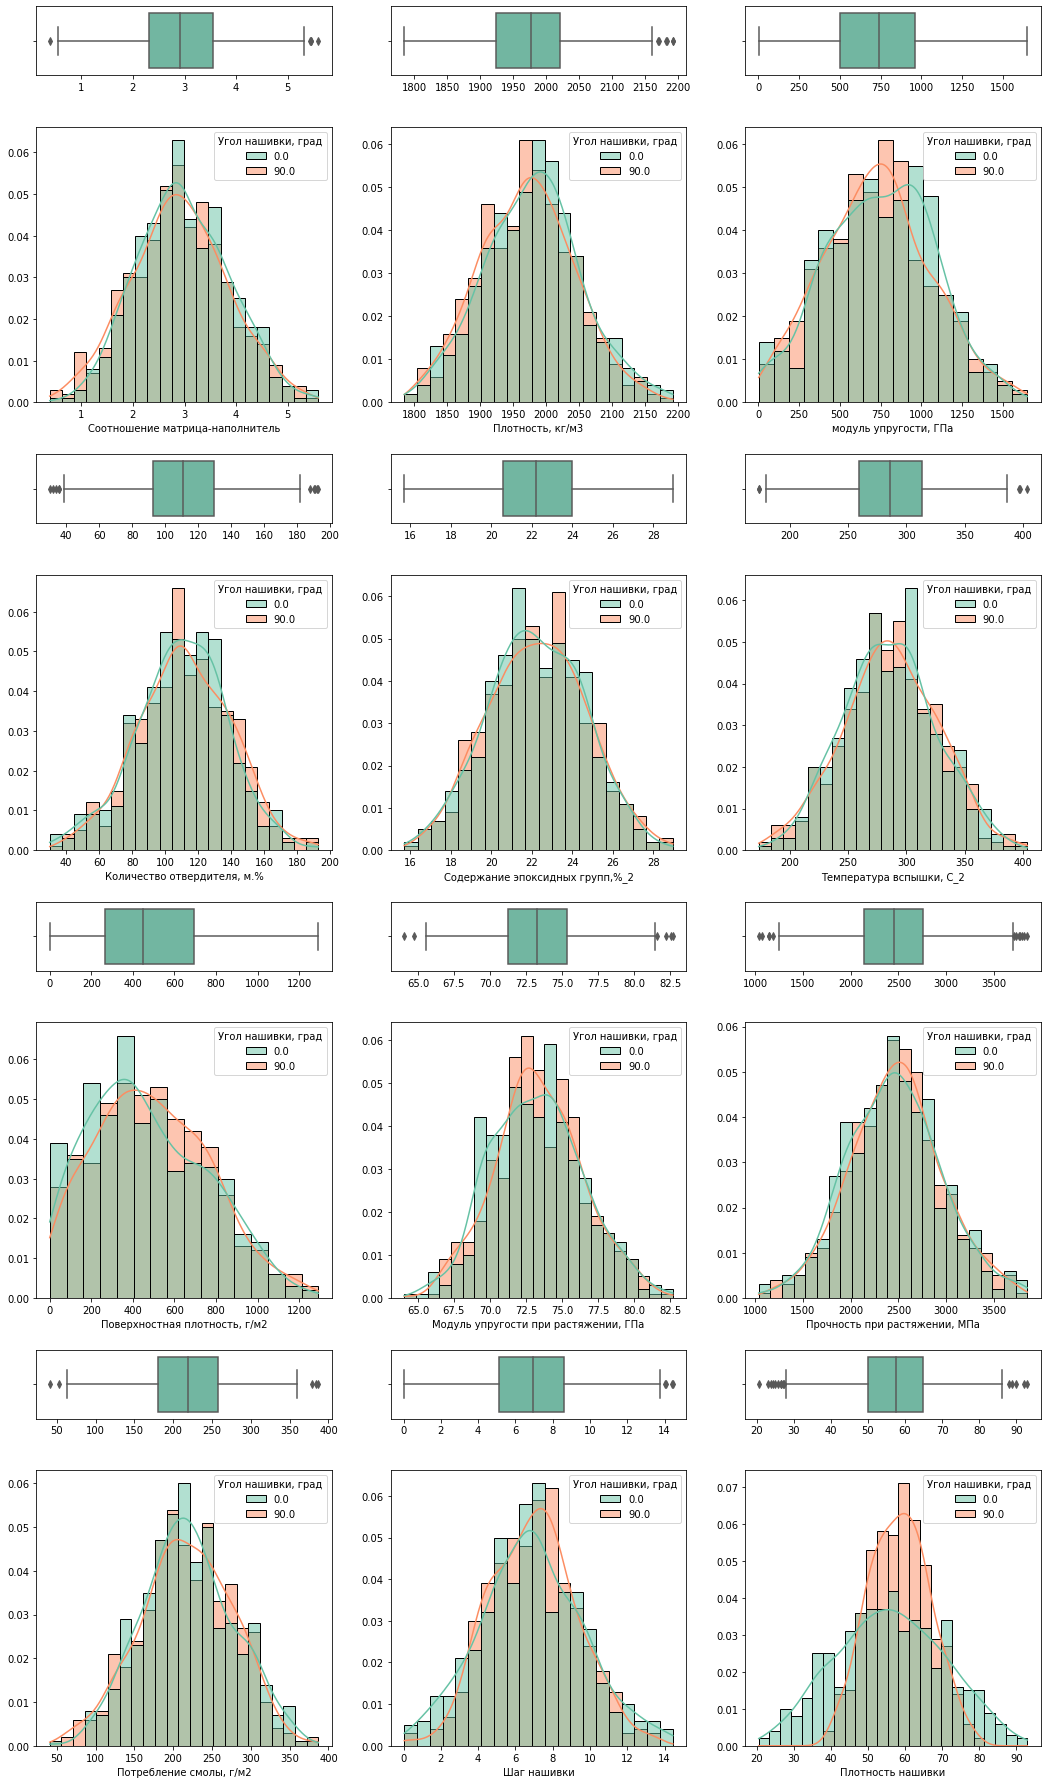

In [ ]:
# Построим те же графики для данных с удаленными выбросами
plot_hist_box(df_fix, df_fix.columns, 'Угол нашивки, град')

По графикам плотности распределения заметны отличия от нормальной формы распределения. После удаления выбросов в данных остались аномалии/шум.

##**Оценка и выбор модели**

In [16]:
# Применим OHE к параметру "Угол нашивки, град"
df_ohe = pd.get_dummies(df_fix, columns = ['Угол нашивки, град'])

In [17]:
# Выберем целевые переменные
y1_col, y2_col, y3_col = 'Соотношение матрица-наполнитель', 'Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа'
y_all = [y1_col, y2_col, y3_col]
y1 = df_ohe[y1_col]
y2 = df_ohe[y2_col]
y3 = df_ohe[y3_col]

In [18]:
# Выберем параметры материалов
x_col = list(set(df_ohe.columns) - set(y_all))
x = df_ohe[x_col]
x.head(3)

,"Плотность, кг/м3","Потребление смолы, г/м2","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Угол нашивки, град_90.0","Угол нашивки, град_0.0","модуль упругости, ГПа","Температура вспышки, С_2","Поверхностная плотность, г/м2",Шаг нашивки,Плотность нашивки
index,,,,,,,,,,,
0,2030.0,220.0,50.00,23.750000,0,1,738.736842,284.615385,210.0,4.0,60.0
1,2030.0,220.0,129.00,21.250000,0,1,738.736842,300.000000,210.0,5.0,47.0
2,2030.0,220.0,111.86,22.267857,0,1,753.000000,284.615385,210.0,5.0,57.0


In [22]:
# Проведем нормализацию параметров
minmax = MinMaxScaler()
x_mm = minmax.fit_transform(x)
x_mm = pd.DataFrame(data = x_mm, columns = x.columns)
x_mm.describe().T

,count,mean,std,min,25%,50%,75%,max
"Плотность, кг/м3",1000.0,0.467648,0.178696,0.0,0.340831,0.472347,0.579727,1.0
"Потребление смолы, г/м2",1000.0,0.512370,0.170432,0.0,0.401220,0.513653,0.625772,1.0
"Количество отвердителя, м.%",1000.0,0.496427,0.171089,0.0,0.384097,0.495388,0.613258,1.0
"Содержание эпоксидных групп,%_2",1000.0,0.493216,0.179818,0.0,0.368597,0.492154,0.624396,1.0
"Угол нашивки, град_90.0",1000.0,0.496000,0.500234,0.0,0.000000,0.000000,1.000000,1.0
"Угол нашивки, град_0.0",1000.0,0.504000,0.500234,0.0,0.000000,1.000000,1.000000,1.0
"модуль упругости, ГПа",1000.0,0.447024,0.198876,0.0,0.302576,0.448525,0.582408,1.0
"Температура вспышки, С_2",1000.0,0.488654,0.174792,0.0,0.371985,0.488205,0.606271,1.0
"Поверхностная плотность, г/м2",1000.0,0.371301,0.215155,0.0,0.206374,0.348844,0.535295,1.0
Шаг нашивки,1000.0,0.477193,0.177586,0.0,0.351886,0.477999,0.593714,1.0


In [23]:
# Разобьем данные на обучающую и тестовую выборки для всех целевых переменных раздельно
x_mm1_trn, x_mm1_tst, y_mm1_trn, y_mm1_tst = train_test_split(x_mm, y1, test_size = 0.3, random_state = 42)
x_mm2_trn, x_mm2_tst, y_mm2_trn, y_mm2_tst = train_test_split(x_mm, y2, test_size = 0.3, random_state = 42)
x_mm3_trn, x_mm3_tst, y_mm3_trn, y_mm3_tst = train_test_split(x_mm, y3, test_size = 0.3, random_state = 42)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
r2_score =  -0.008639692541356103
mae =  2.481045887535015


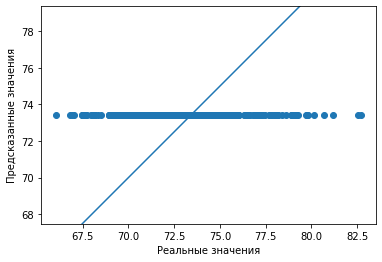

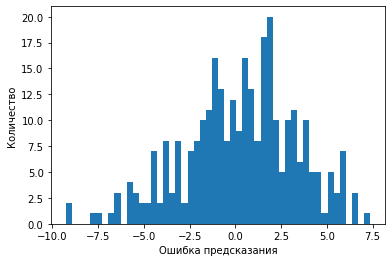

In [24]:
# Настроим сетку для выбора оптимальных параметров метода RandomForestRegressor для второй целевой переменной

# Параметры для RandomForestRegressor
par_rfr = {'n_estimators' : [30, 40, 50],
              'criterion' : ['absolute_error'],
               'ccp_alpha': [0.1, 0.3, 0.5]
             }

rfr2 = RandomForestRegressor(random_state = 42)
gs2 = GridSearchCV(estimator = rfr2, param_grid = par_rfr, cv = 10, verbose = True)
gs2.fit(x_mm2_trn, y_mm2_trn)
rfr2_best = gs2.best_estimator_
print('r2_score = ', r2_score(y_mm2_tst, rfr2_best.predict(x_mm2_tst)))
print('mae = ', mean_absolute_error(y_mm2_tst, rfr2_best.predict(x_mm2_tst)))
test_predictions = rfr2_best.predict(x_mm2_tst).flatten()
plot_prediction(y_mm2_tst, test_predictions)

In [25]:
rfr2_best

RandomForestRegressor(ccp_alpha=0.3, criterion='absolute_error',
                      n_estimators=40, random_state=42)

In [51]:
# На тренировочной выборке
print('r2_score = ', r2_score(y_mm2_trn, rfr2_best.predict(x_mm2_trn)))
print('mae = ', mean_absolute_error(y_mm2_trn, rfr2_best.predict(x_mm2_trn)))

r2_score =  -2.899161840264064e-05
mae =  2.505396473964767


Модель не сумела обобщить тестовые данные. 
Коэффициент детерминации ниже нуля.

Fitting 10 folds for each of 9 candidates, totalling 90 fits
r2_score =  -0.08353355740548563
mae =  380.0859663528316


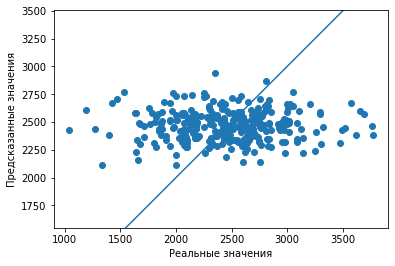

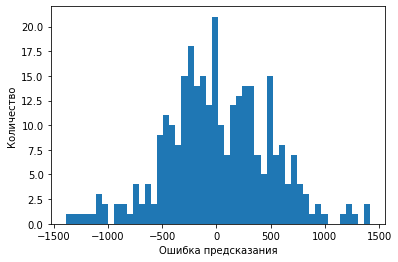

In [26]:
# Воспользуемся предыдущей моделью для предсказания третьей целевой переменной
# Параметры для RandomForestRegressor
par_rfr = {'n_estimators' : [30, 40, 50],
              'criterion' : ['absolute_error'],
               'ccp_alpha': [0.1, 0.3, 0.5]
             }

rfr3 = RandomForestRegressor(random_state = 42)
gs3 = GridSearchCV(estimator = rfr3, param_grid = par_rfr, cv = 10, verbose = True)
gs3.fit(x_mm3_trn, y_mm3_trn)
rfr3_best = gs3.best_estimator_
print('r2_score = ', r2_score(y_mm3_tst, rfr3_best.predict(x_mm3_tst)))
print('mae = ', mean_absolute_error(y_mm3_tst, rfr3_best.predict(x_mm3_tst)))
test_predictions = rfr3_best.predict(x_mm3_tst).flatten()
plot_prediction(y_mm3_tst, test_predictions)

In [28]:
rfr3_best

RandomForestRegressor(ccp_alpha=0.1, criterion='absolute_error',
                      n_estimators=50, random_state=42)

In [58]:
# На тренировочной выборке
print('r2_score = ', r2_score(y_mm3_trn, rfr3_best.predict(x_mm3_trn)))
print('mae = ', mean_absolute_error(y_mm3_trn, rfr3_best.predict(x_mm3_trn)))

r2_score =  0.8417707694175655
mae =  151.62055679495674


Для третьего целевого параметра результат такой же.

Fitting 10 folds for each of 6 candidates, totalling 60 fits
r2_score =  -0.03959141602230942
mae =  2.5310532068342044


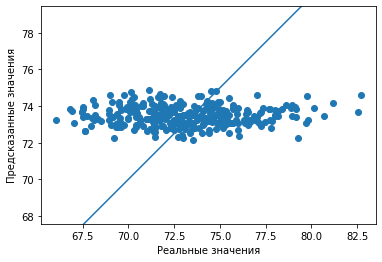

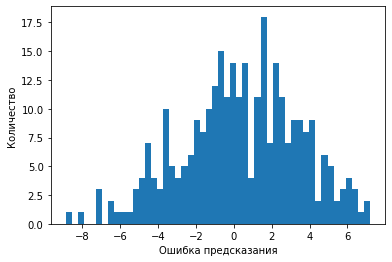

In [27]:
# Настроим сетку для выбора оптимальных параметров метода AdaBoostRegressor для второй целевой переменной

# Параметры для AdaBoostRegressor
par_abr = {'n_estimators' : [30, 40, 50],
                   'loss' : ['linear'],
          'learning_rate' : [0.1, 0.5]
           } 

abr2 = AdaBoostRegressor(base_estimator = SVR(kernel = 'linear'), random_state = 42)
gs2_abr = GridSearchCV(estimator = abr2, param_grid = par_abr, cv = 10, verbose = True)
gs2_abr.fit(x_mm2_trn, y_mm2_trn)
abr2_best = gs2_abr.best_estimator_
print('r2_score = ', r2_score(y_mm2_tst, abr2_best.predict(x_mm2_tst)))
print('mae = ', mean_absolute_error(y_mm2_tst, abr2_best.predict(x_mm2_tst)))
test_predictions = abr2_best.predict(x_mm2_tst).flatten()
plot_prediction(y_mm2_tst, test_predictions)

Результат получился немного хуже, чем у метода случайного леса. Но все равно ошибка велика.

In [29]:
abr2_best

AdaBoostRegressor(base_estimator=SVR(kernel='linear'), learning_rate=0.1,
                  n_estimators=30, random_state=42)

In [53]:
# На тренировочной выборке
print('r2_score = ', r2_score(y_mm2_trn, abr2_best.predict(x_mm2_trn)))
print('mae = ', mean_absolute_error(y_mm2_trn, abr2_best.predict(x_mm2_trn)))

r2_score =  0.02962578345072009
mae =  2.4441853658992962


Fitting 10 folds for each of 6 candidates, totalling 60 fits
r2_score =  0.00013238916334357143
mae =  363.7433876007583


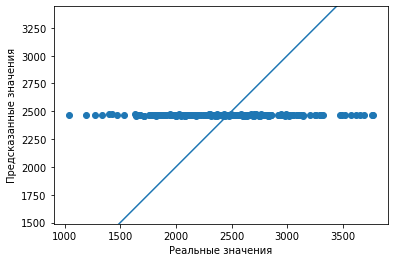

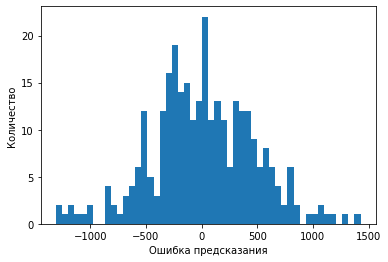

In [30]:
# Настроим сетку для выбора оптимальных параметров метода AdaBoostRegressor для третьей целевой переменной

# Параметры для AdaBoostRegressor
par_abr = {'n_estimators' : [30, 40, 50],
                   'loss' : ['linear'],
          'learning_rate' : [0.1, 0.5]
           } 

abr3 = AdaBoostRegressor(base_estimator = SVR(kernel = 'linear'), random_state = 42)
gs3_abr = GridSearchCV(estimator = abr3, param_grid = par_abr, cv = 10, verbose = True)
gs3_abr.fit(x_mm3_trn, y_mm3_trn)
abr3_best = gs3_abr.best_estimator_
print('r2_score = ', r2_score(y_mm3_tst, abr3_best.predict(x_mm3_tst)))
print('mae = ', mean_absolute_error(y_mm3_tst, abr3_best.predict(x_mm3_tst)))
test_predictions = abr3_best.predict(x_mm3_tst).flatten()
plot_prediction(y_mm3_tst, test_predictions)

In [31]:
abr3_best

AdaBoostRegressor(base_estimator=SVR(kernel='linear'), learning_rate=0.1,
                  random_state=42)

In [54]:
# На тренировочной выборке
print('r2_score = ', r2_score(y_mm3_trn, abr3_best.predict(x_mm3_trn)))
print('mae = ', mean_absolute_error(y_mm3_trn, abr3_best.predict(x_mm3_trn)))

r2_score =  0.0018583437570872663
mae =  389.76390384842716


Результат чуть лучше, чем у метода случайного леса. Но модель все равно не смогла обощить тестовые данные.

Fitting 10 folds for each of 6 candidates, totalling 60 fits
r2_score =  -0.06529579945899533
mae =  2.576484531784189


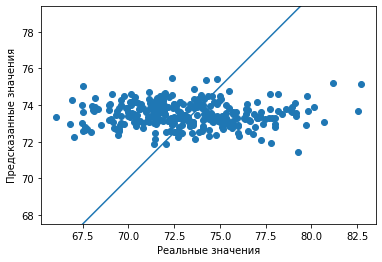

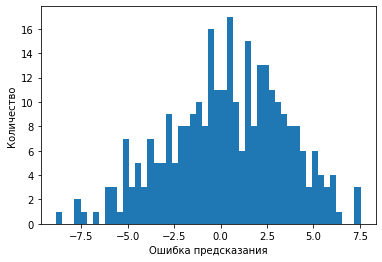

In [32]:
# Настроим сетку для выбора оптимальных параметров метода AdaBoostRegressor для второй целевой переменной, но сменим функцию ядра

# Параметры для AdaBoostRegressor
par_abr = {'n_estimators' : [30, 40, 50],
                   'loss' : ['linear'],
          'learning_rate' : [0.1, 0.5]
           } 

abr21 = AdaBoostRegressor(base_estimator = SVR(kernel = 'rbf'), random_state = 42)
gs21_abr = GridSearchCV(estimator = abr21, param_grid = par_abr, cv = 10, verbose = True)
gs21_abr.fit(x_mm2_trn, y_mm2_trn)
abr21_best = gs21_abr.best_estimator_
print('r2_score = ', r2_score(y_mm2_tst, abr21_best.predict(x_mm2_tst)))
print('mae = ', mean_absolute_error(y_mm2_tst, abr21_best.predict(x_mm2_tst)))
test_predictions = abr21_best.predict(x_mm2_tst).flatten()
plot_prediction(y_mm2_tst, test_predictions)

In [33]:
abr21_best

AdaBoostRegressor(base_estimator=SVR(), learning_rate=0.1, n_estimators=30,
                  random_state=42)

In [56]:
# На тренировочной выборке
print('r2_score = ', r2_score(y_mm2_trn, abr21_best.predict(x_mm2_trn)))
print('mae = ', mean_absolute_error(y_mm2_trn, abr21_best.predict(x_mm2_trn)))

r2_score =  0.11948001538999764
mae =  2.2892919434802677


Fitting 10 folds for each of 6 candidates, totalling 60 fits
r2_score =  -0.00021019597794680323
mae =  363.75790244340595


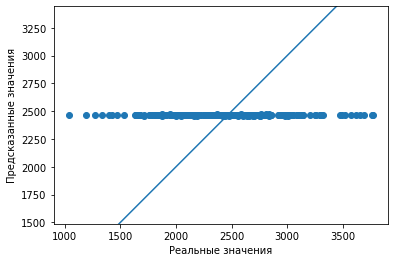

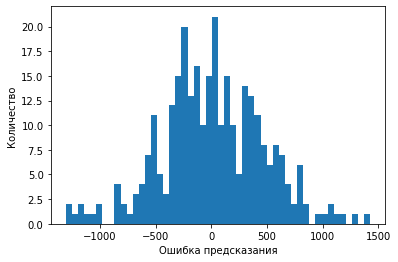

In [36]:
# Настроим сетку для выбора оптимальных параметров метода AdaBoostRegressor для третьей целевой переменной, но сменим функцию ядра

# Параметры для AdaBoostRegressor
par_abr = {'n_estimators' : [30, 40, 50],
                   'loss' : ['linear'],
          'learning_rate' : [0.1, 0.5]
           } 

abr31 = AdaBoostRegressor(base_estimator = SVR(kernel = 'rbf'), random_state = 42)
gs31_abr = GridSearchCV(estimator = abr31, param_grid = par_abr, cv = 10, verbose = True)
gs31_abr.fit(x_mm3_trn, y_mm3_trn)
abr31_best = gs31_abr.best_estimator_
print('r2_score = ', r2_score(y_mm3_tst, abr31_best.predict(x_mm3_tst)))
print('mae = ', mean_absolute_error(y_mm3_tst, abr31_best.predict(x_mm3_tst)))
test_predictions = abr31_best.predict(x_mm3_tst).flatten()
plot_prediction(y_mm3_tst, test_predictions)

In [37]:
abr31_best

AdaBoostRegressor(base_estimator=SVR(), learning_rate=0.1, random_state=42)

In [57]:
# На тренировочной выборке
print('r2_score = ', r2_score(y_mm3_trn, abr31_best.predict(x_mm3_trn)))
print('mae = ', mean_absolute_error(y_mm3_trn, abr31_best.predict(x_mm3_trn)))

r2_score =  0.0022441329956427447
mae =  389.54396280181896


С функцией ядра "rbf" результаты оказались совсем немного хуже, чем с "linear".

In [66]:
# Построим нейронную сеть для предсказания первой целевой переменной
model = Sequential()
model.add(Input(shape=(x_mm1_trn.shape[1],)))
model.add(Normalization(axis=-1))
model.add(Dense(64, activation = tf.nn.relu))
model.add(Dropout(0.4))
model.add(Dense(64, activation = tf.nn.relu))
model.add(Dropout(0.3))
model.add(Dense(64, activation = tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['mae'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 11)               23        
 ion)                                                            
                                                                 
 dense_16 (Dense)            (None, 64)                768       
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                      

r2_score =  0.0030707099366111823
mae =  0.731535877329348


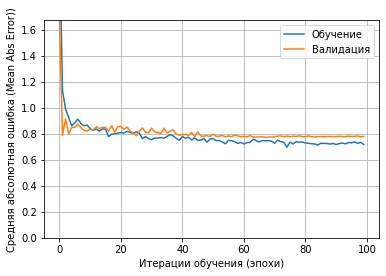

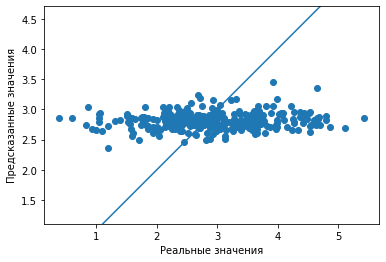

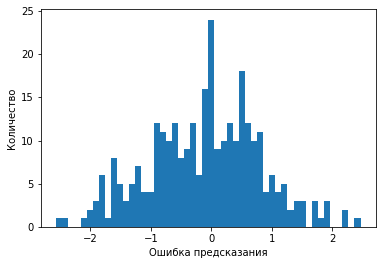

In [67]:
history = model.fit(x_mm1_trn, y_mm1_trn, batch_size = 32, epochs = 100, verbose = 0, validation_split=0.2)
print('r2_score = ', r2_score(y_mm1_tst, model.predict(x_mm1_tst)))
print('mae = ', mean_absolute_error(y_mm1_tst, model.predict(x_mm1_tst)))
plot_history(history)
test_predictions = model.predict(x_mm1_tst).flatten()
plot_prediction(y_mm1_tst, test_predictions)

In [68]:
# На тренировочной выборке
print('r2_score = ', r2_score(y_mm1_trn, model.predict(x_mm1_trn)))
print('mae = ', mean_absolute_error(y_mm1_trn, model.predict(x_mm1_trn)))

r2_score =  0.030439039016524894
mae =  0.7089417282666975


In [ ]:
# Создадим Conv1D модель

In [ ]:
# Сделаем reshape данных для новой модели

In [64]:
sample_size = x_mm1_trn.shape[0]
time_steps  = x_mm1_trn.shape[1]
input_dimension = 1             

x_mm1_res_trn = np.array(x_mm1_trn).reshape(sample_size,time_steps,input_dimension)
print("x_mm1_res_trn.shape:\n", x_mm1_res_trn.shape)
print("1 наблюдение:\n",x_mm1_res_trn[0].shape)
print("пример наблюдения:\n", x_mm1_res_trn[0])

x_mm1_res_trn.shape:
 (700, 11, 1)
1 наблюдение:
 (11, 1)
пример наблюдения:
 [[0.04276343]
 [0.46852095]
 [0.63649185]
 [0.62983272]
 [1.        ]
 [0.        ]
 [0.44112821]
 [0.36907727]
 [0.76197843]
 [0.44418591]
 [0.48622653]]


In [48]:
x_mm1_res_tst = np.array(x_mm1_tst).reshape(x_mm1_tst.shape[0], x_mm1_tst.shape[1], 1)
x_mm1_res_tst.shape

(300, 11, 1)

In [69]:
#==1
n_timesteps = 11 #x_mm1_res_trn.shape[1] 
n_features  = 1  #x_mm1_res_trn.shape[2]  
model = keras.Sequential(name="model_conv1D")
model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
model.add(keras.layers.Normalization(axis=-1))
model.add(keras.layers.Conv1D(filters=8, kernel_size=6, activation='relu', name="Conv1D_1"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Conv1D(filters=4, kernel_size=3, activation='relu', name="Conv1D_2"))
#model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Conv1D(filters=2, kernel_size=2, padding = 'same', activation='relu', name="Conv1D_3"))
model.add(keras.layers.MaxPool1D(pool_size=2, name="MaxPooling1D"))
#model.add(keras.layers.Conv1D(filters=4, kernel_size=2, padding = 'same', activation='relu', name="Conv1D_4"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='elu', name="Dense_1"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(128, activation='elu', name="Dense_2"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(128, activation='relu', name="Dense_3"))
model.add(keras.layers.Dense(n_features, name="Dense_end"))

optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(loss='mse',optimizer=optimizer,metrics=['mae'])

model.summary()

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 11, 1)            3         
 ion)                                                            
                                                                 
 Conv1D_1 (Conv1D)           (None, 6, 8)              56        
                                                                 
 dropout_18 (Dropout)        (None, 6, 8)              0         
                                                                 
 Conv1D_2 (Conv1D)           (None, 4, 4)              100       
                                                                 
 Conv1D_3 (Conv1D)           (None, 4, 2)              18        
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 2, 2)             0         
                                                      

r2_score =  -0.02245739933980828
mae =  0.7559355453711315


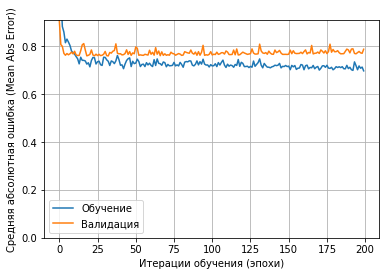

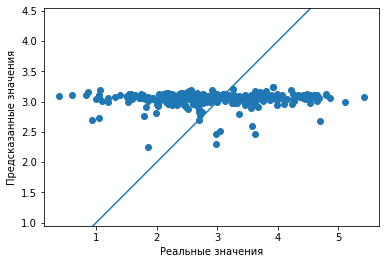

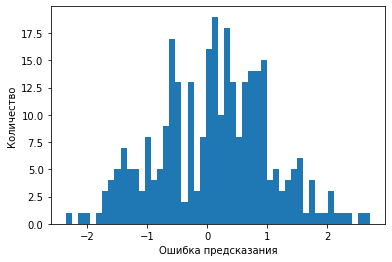

In [70]:
history = model.fit(x_mm1_res_trn, y_mm1_trn, batch_size = 32, epochs = 200, verbose = 0, validation_split=0.2)
print('r2_score = ', r2_score(y_mm1_tst, model.predict(x_mm1_res_tst)))
print('mae = ', mean_absolute_error(y_mm1_tst, model.predict(x_mm1_res_tst)))
plot_history(history)
test_predictions = model.predict(x_mm1_res_tst).flatten()
plot_prediction(y_mm1_tst, test_predictions)

In [71]:
print('r2_score = ', r2_score(y_mm1_trn, model.predict(x_mm1_res_trn)))
print('mae = ', mean_absolute_error(y_mm1_trn, model.predict(x_mm1_res_trn)))

r2_score =  0.017272988392497912
mae =  0.7176691947995766
